In [3]:
import pandas as pd
import numpy as np
import colorsys
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Rectangle
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator

pd.options.mode.chained_assignment = None  # default='warn'

# Color schema

In [4]:
from color_schema import *

In [5]:
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
class CustomTransform(Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True
    has_inverse = True

    def __init__(self, threshold, lower_range, upper_range):
        Transform.__init__(self)
        self.threshold = threshold
        self.lower_range = lower_range
        self.upper_range = upper_range

    def transform_non_affine(self, a):
        a = np.maximum(a, 10**self.lower_range)  # Clip values to the minimum of the lower range
        mask = a < self.threshold
        out = np.empty(a.shape, dtype=np.float64)
        out[mask] = 0.7 * (np.log10(a[mask]) - self.lower_range) / (np.log10(self.threshold) - self.lower_range)
        out[~mask] = 0.7 + 0.3 * (np.log10(a[~mask]) - np.log10(self.threshold)) / (self.upper_range - np.log10(self.threshold))
        return out

    def inverted(self):
        return CustomTransform.InvertedCustomTransform(self.threshold, self.lower_range, self.upper_range)

    class InvertedCustomTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, threshold, lower_range, upper_range):
            Transform.__init__(self)
            self.threshold = threshold
            self.lower_range = lower_range
            self.upper_range = upper_range

        def transform_non_affine(self, a):
            mask = a < 0.7
            out = np.empty(a.shape, dtype=np.float64)
            out[mask] = 10 ** (self.lower_range + a[mask] / 0.7 * (np.log10(self.threshold) - self.lower_range))
            out[~mask] = 10 ** (np.log10(self.threshold) + (a[~mask] - 0.7) / 0.3 * (self.upper_range - np.log10(self.threshold)))
            return out

        def inverted(self):
            return CustomTransform(self.threshold, self.lower_range, self.upper_range)

class CustomScale(ScaleBase):
    name = 'custom'

    def __init__(self, axis, threshold=1e6, lower_range=-6, upper_range=34, **kwargs):
        ScaleBase.__init__(self, axis)
        self.threshold = threshold
        self.lower_range = lower_range
        self.upper_range = upper_range

    def get_transform(self):
        return CustomTransform(self.threshold, self.lower_range, self.upper_range)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(plt.FixedLocator([10**i for i in range(self.lower_range, self.upper_range+1, 3)]))
        axis.set_major_formatter(FuncFormatter(lambda x, p: f'$10^{{{int(np.log10(x))}}}$'))
        axis.set_minor_locator(plt.NullLocator())
        axis.set_minor_formatter(plt.NullFormatter())

register_scale(CustomScale)

def draw_combined_trend_plot(dataframes, titles, methods_list, output_filename, label_total_width=0.5, label_start_x=0.09, draw_middle_line=False):
    fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size

    num_dfs = len(dataframes)
    
    all_methods = set(method for methods in methods_list for method in methods)

    # Calculate the width for each benchmark based on its number of methods
    benchmark_widths = [len(methods) for methods in methods_list]
    total_methods = sum(benchmark_widths)
    total_width = 0.9 * num_dfs  # Increased total width to reduce margins
    width_per_method = total_width / total_methods

    # Calculate fixed_width and padding
    fixed_width = width_per_method * 0.8  # 80% of width_per_method for each box
    benchmark_padding = width_per_method * 0.3  # 20% of width_per_method for padding

    # Calculate positions for each benchmark
    positions = []
    benchmark_starts = [0]
    current_pos = 0
    gap = 0  # Adjust this value to increase or decrease the gap between benchmarks
    for width in benchmark_widths:
        benchmark_width = width * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap  # Add the gap after each benchmark
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, (df, methods) in enumerate(zip(dataframes, methods_list)):
        benchmark_start = benchmark_starts[i]
        benchmark_width = benchmark_starts[i+1] - benchmark_start
        usable_width = benchmark_width - 2 * benchmark_padding
        
        present_categories = [cat for cat, cat_methods in categories.items() if any(m in methods for m in cat_methods)]
        
        # Calculate the total number of methods across all categories
        total_methods_in_benchmark = sum(len([m for m in categories[cat] if m in methods]) for cat in present_categories)
        
        # Calculate the width for each box
        box_width = usable_width / total_methods_in_benchmark
        
        category_start = benchmark_start + benchmark_padding
        for category in present_categories:
            category_methods = [m for m in categories[category] if m in methods]
            category_width = len(category_methods) * box_width
            
            # Draw category background
            rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)
            
            # Position boxes within the category
            for k, method in enumerate(category_methods):
                if method in all_methods:
                    df_filtered = df[df["cardinality"] != 0]
                    df_filtered.loc[:, f"{method}_error"] = df_filtered[method] / df_filtered["cardinality"]
                    method_data = df_filtered[f"{method}_error"]
                    
                    box_pos = category_start + (k + 0.5) * box_width
                    bp = ax.boxplot([method_data], 
                                    positions=[box_pos], 
                                    widths=box_width * 0.8,
                                    patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Set x-axis ticks and labels
    ax.set_xticks(positions)
    
    x_labels = [f"{title}\n({len(df)} queries)" for df, title in zip(dataframes, titles)]
    ax.set_xticklabels(x_labels)

    for label in ax.get_xticklabels():
        label.set_fontsize(18)

    plt.ylabel("Estimation Error", fontsize=26)
    
    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in all_methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        total_width = label_total_width
        box_width = total_width / len(filtered_categories)
        start_x = label_start_x

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            
            for method in category_methods:
                if method in all_methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(patches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            bbox_to_anchor=(start_x + i * box_width, 0.98),
                            bbox_transform=ax.transAxes,
                            fontsize=18,
                            title_fontsize=18,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)


    plt.xticks(fontsize=24)
    plt.yticks(fontsize=18)

    plt.yscale('custom', threshold=1e6, lower_range=-6, upper_range=34)

    major_ticks = [1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e10, 1e14, 1e18, 1e22, 1e26, 1e30, 1e34]
    ax.set_yticks(major_ticks)
    
    minor_ticks = []
    for i in range(len(major_ticks) - 1):
        log_start = np.log10(major_ticks[i])
        log_end = np.log10(major_ticks[i+1])
        minor_ticks.extend(np.logspace(log_start, log_end, num=9, endpoint=False)[1:])
    ax.set_yticks(minor_ticks, minor=True)

    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=0.6)

    # Add vertical lines between benchmarks
    for end in benchmark_starts[1:-1]:
        ax.axvline(end, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Add a very visible vertical line in the middle
    if draw_middle_line:
        ax.axvline(benchmark_starts[3], color='black', linestyle='--', linewidth=2.5, alpha=0.9)
    
    # Adjust x-axis limits to reduce margins
    ax.set_xlim(0, benchmark_starts[-1])

    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    
    # create plots dir if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)



In [6]:
def draw_full_estimates(benchmark="joblight"):

    # read the estimates from the csv file for each method
    methods = [
        "lpbound",
        "safebound",
        "dbx",
        "duckdb",
        "postgres",
        "factorjoin",
        "neurocard", "bayescard", "deepdb", "flat" # ML-based methods
    ]

    this_methods = []
    overall_df = pd.DataFrame()
    for method in methods:
        file = f"../results/accuracy_acyclic/{benchmark}/{method}_{benchmark}_full_estimations.csv"
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        df = pd.read_csv(file)
        if "QueryID" not in overall_df:
            overall_df["QueryID"] = df["QueryID"]
        else:
            assert (overall_df["QueryID"] == df["QueryID"]).all()

        overall_df[method] = df[f"{method}_Estimate"]
        this_methods.append(method)
    
    # read the true cardinality
    df = pd.read_csv(f"../results/accuracy_acyclic/{benchmark}/truecardinality_{benchmark}_full_estimations.csv")
    overall_df["cardinality"] = df["truecardinality_Estimate"]

    # read the relation counts
    df = pd.read_csv(f"../workloads/{benchmark}/{benchmark}_relation_counts.csv")
    overall_df["Relations"] = df["Relations"]

    this_title = benchmark_names[benchmark]

    return overall_df, this_title, this_methods



# Figure 5: Estimation Error for Acyclic Full Queries

File ../results/accuracy_acyclic/jobjoin/neurocard_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/bayescard_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/deepdb_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/flat_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/neurocard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/bayescard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/deepdb_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/flat_jobrange_full_estimations.csv does not exist


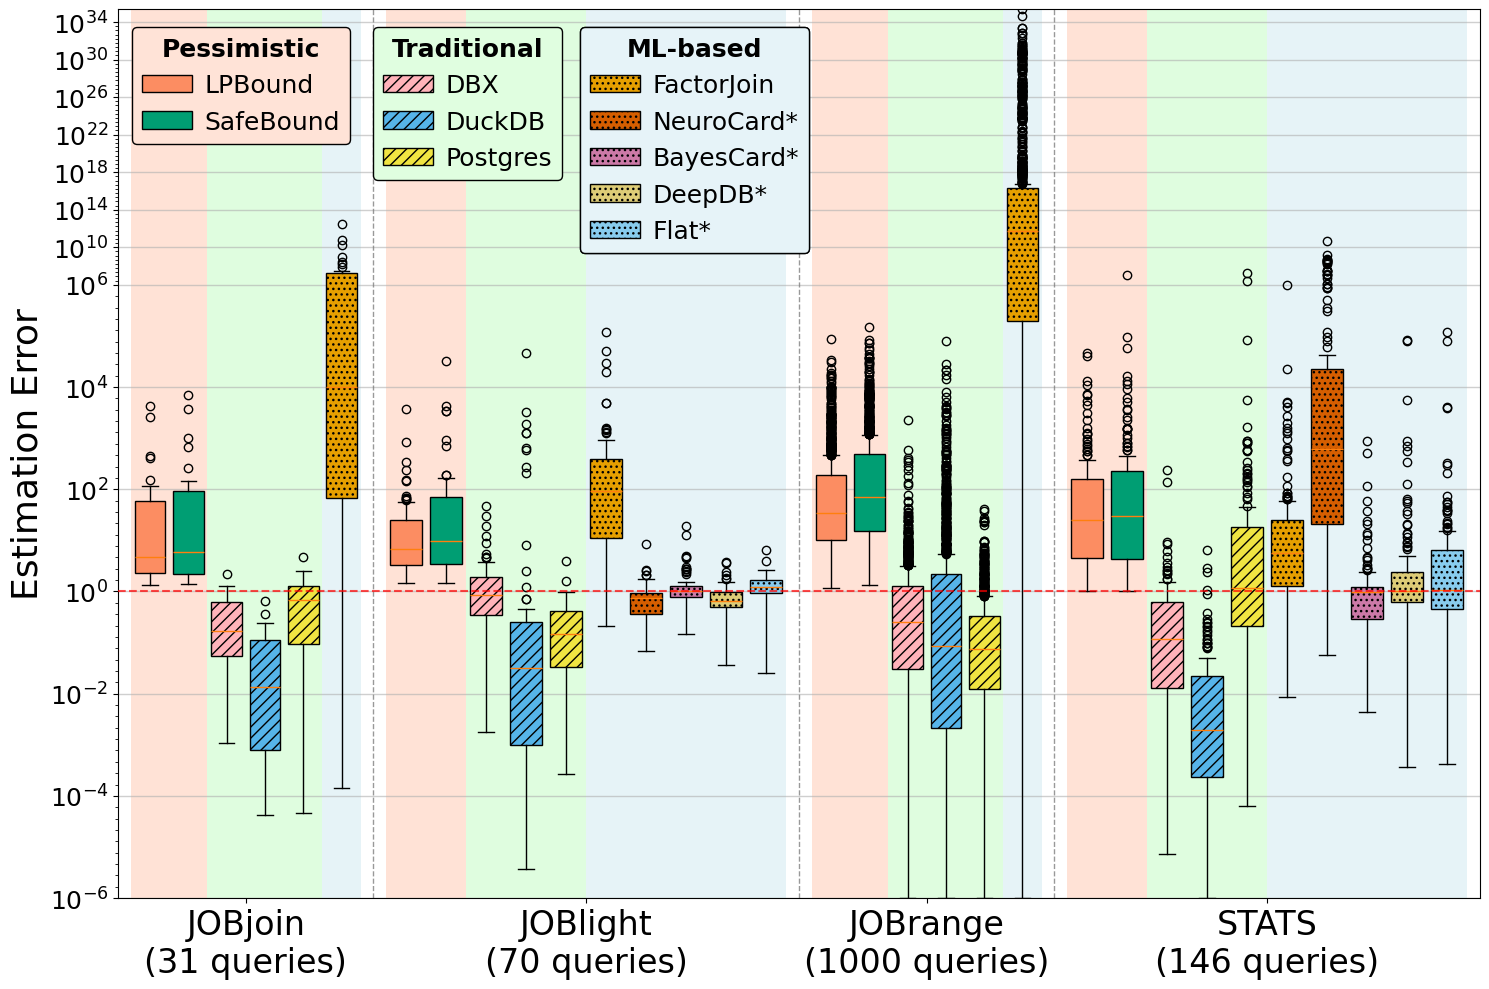

In [7]:

df0, title0, methods0 = draw_full_estimates("jobjoin")
df1, title1, methods1 = draw_full_estimates("joblight")
df2, title2, methods2 = draw_full_estimates("jobrange")
df3, title3, methods3 = draw_full_estimates("stats")

draw_combined_trend_plot([df0, df1, df2, df3], [title0, title1, title2, title3], [methods0, methods1, methods2, methods3], "estimates_combined.pdf")

In [12]:
def draw_combined_trend_plot(dataframes, titles, methods_list, all_possible_methods, output_filename, label_total_width=0.5, label_start_x=0.09, draw_middle_line=False):
    fig, ax = plt.subplots(figsize=(15, 10))

    num_dfs = len(dataframes)
    
    # Use all_possible_methods for width calculations
    total_possible_methods = set(method for methods in all_possible_methods for method in methods)

    # Calculate widths based on all possible methods
    benchmark_widths = [len(methods) for methods in all_possible_methods]
    total_methods = sum(benchmark_widths)
    total_width = 0.9 * num_dfs
    width_per_method = total_width / total_methods

    fixed_width = width_per_method * 0.8
    benchmark_padding = width_per_method * 0.3

    positions = []
    benchmark_starts = [0]
    current_pos = 0
    gap = 0
    for width in benchmark_widths:
        benchmark_width = width * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, (df, methods) in enumerate(zip(dataframes, methods_list)):
        benchmark_start = benchmark_starts[i]
        benchmark_width = benchmark_starts[i+1] - benchmark_start
        usable_width = benchmark_width - 2 * benchmark_padding
        
        # Use all possible categories for positioning
        all_categories = ['Pessimistic', 'Traditional', 'ML-based']
        
        # Calculate total methods using all_possible_methods for this benchmark
        total_methods_in_benchmark = len(all_possible_methods[i])
        box_width = usable_width / total_methods_in_benchmark
        
        category_start = benchmark_start + benchmark_padding
        for category in all_categories:
            category_methods = [m for m in categories[category] if m in all_possible_methods[i]]
            category_width = len(category_methods) * box_width
            
            # Draw background only if category has visible methods
            if any(m in methods for m in category_methods):
                rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                      fill=True, facecolor=category_colors[category], 
                                      alpha=0.3, transform=ax.get_xaxis_transform(), 
                                      zorder=0)
                ax.add_patch(rect)
            
            # Position boxes for visible methods
            for k, method in enumerate(category_methods):
                if method in methods:
                    df_filtered = df[df["cardinality"] != 0]
                    df_filtered.loc[:, f"{method}_error"] = df_filtered[method] / df_filtered["cardinality"]
                    method_data = df_filtered[f"{method}_error"]
                    
                    box_pos = category_start + (k + 0.5) * box_width
                    bp = ax.boxplot([method_data], 
                                  positions=[box_pos], 
                                  widths=box_width * 0.8,
                                  patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Set x-axis ticks and labels
    ax.set_xticks(positions)
    x_labels = [f"{title}\n({len(df)} queries)" for df, title in zip(dataframes, titles)]
    ax.set_xticklabels(x_labels)

    for label in ax.get_xticklabels():
        label.set_fontsize(18)

    plt.ylabel("Estimation Error", fontsize=26)
    
    # Create legends only for visible categories
    filtered_categories = []
    for category, category_methods in categories.items():
        # Check if any method from this category is in the current visible methods
        present_methods = [method for method in category_methods 
                         if any(method in benchmark_methods for benchmark_methods in methods_list)]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        box_width = label_total_width / len(filtered_categories)
        box_width = 0.16

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            
            # Use all methods that are present in any benchmark
            for method in category_methods:
                if any(method in benchmark_methods for benchmark_methods in methods_list):
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(patches.Rectangle((0, 0), 1, 1, 
                                        facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            if legend_elements:  # Only create legend if there are elements
                legend = ax.legend(legend_elements, legend_labels,
                                title=category,
                                loc='upper center',
                                bbox_to_anchor=(label_start_x + i * box_width, 0.98),
                                bbox_transform=ax.transAxes,
                                fontsize=18,
                                title_fontsize=18,
                                frameon=True,
                                edgecolor='black',
                                borderaxespad=0,
                                handletextpad=0.5,
                                columnspacing=1.0)
                
                legend.get_title().set_fontweight('bold')
                frame = legend.get_frame()
                lightened_color = lighten_color(category_colors[category], amount=0.3)
                frame.set_facecolor(lightened_color)
                frame.set_alpha(1.0)
                
                legends.append(legend)
        
        for legend in legends:
            ax.add_artist(legend)


    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)

    plt.yscale('custom', threshold=1e6, lower_range=-6, upper_range=34)

    major_ticks = [1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e10, 1e14, 1e18, 1e22, 1e26, 1e30, 1e34]
    ax.set_yticks(major_ticks)
    
    minor_ticks = []
    for i in range(len(major_ticks) - 1):
        log_start = np.log10(major_ticks[i])
        log_end = np.log10(major_ticks[i+1])
        minor_ticks.extend(np.logspace(log_start, log_end, num=9, endpoint=False)[1:])
    ax.set_yticks(minor_ticks, minor=True)

    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=0.6)

    for end in benchmark_starts[1:-1]:
        ax.axvline(end, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    if draw_middle_line:
        ax.axvline(benchmark_starts[3], color='black', linestyle='--', linewidth=2.5, alpha=0.9)
    
    ax.set_xlim(0, benchmark_starts[-1])
    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


File ../results/accuracy_acyclic/jobjoin/neurocard_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/bayescard_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/deepdb_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobjoin/flat_jobjoin_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/neurocard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/bayescard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/deepdb_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/flat_jobrange_full_estimations.csv does not exist


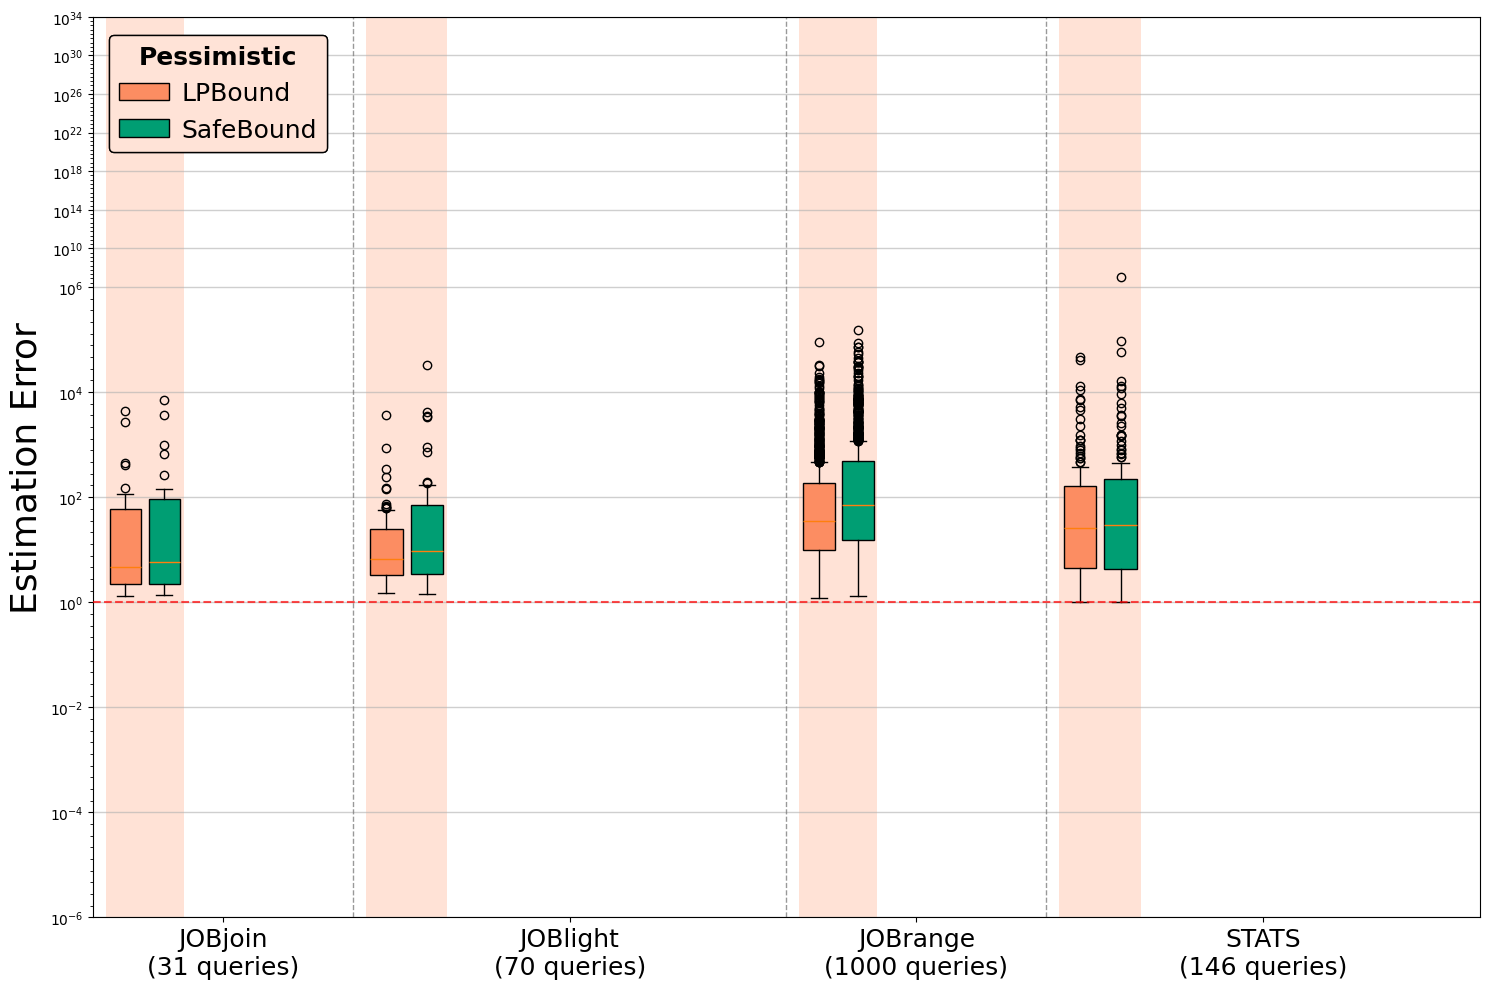

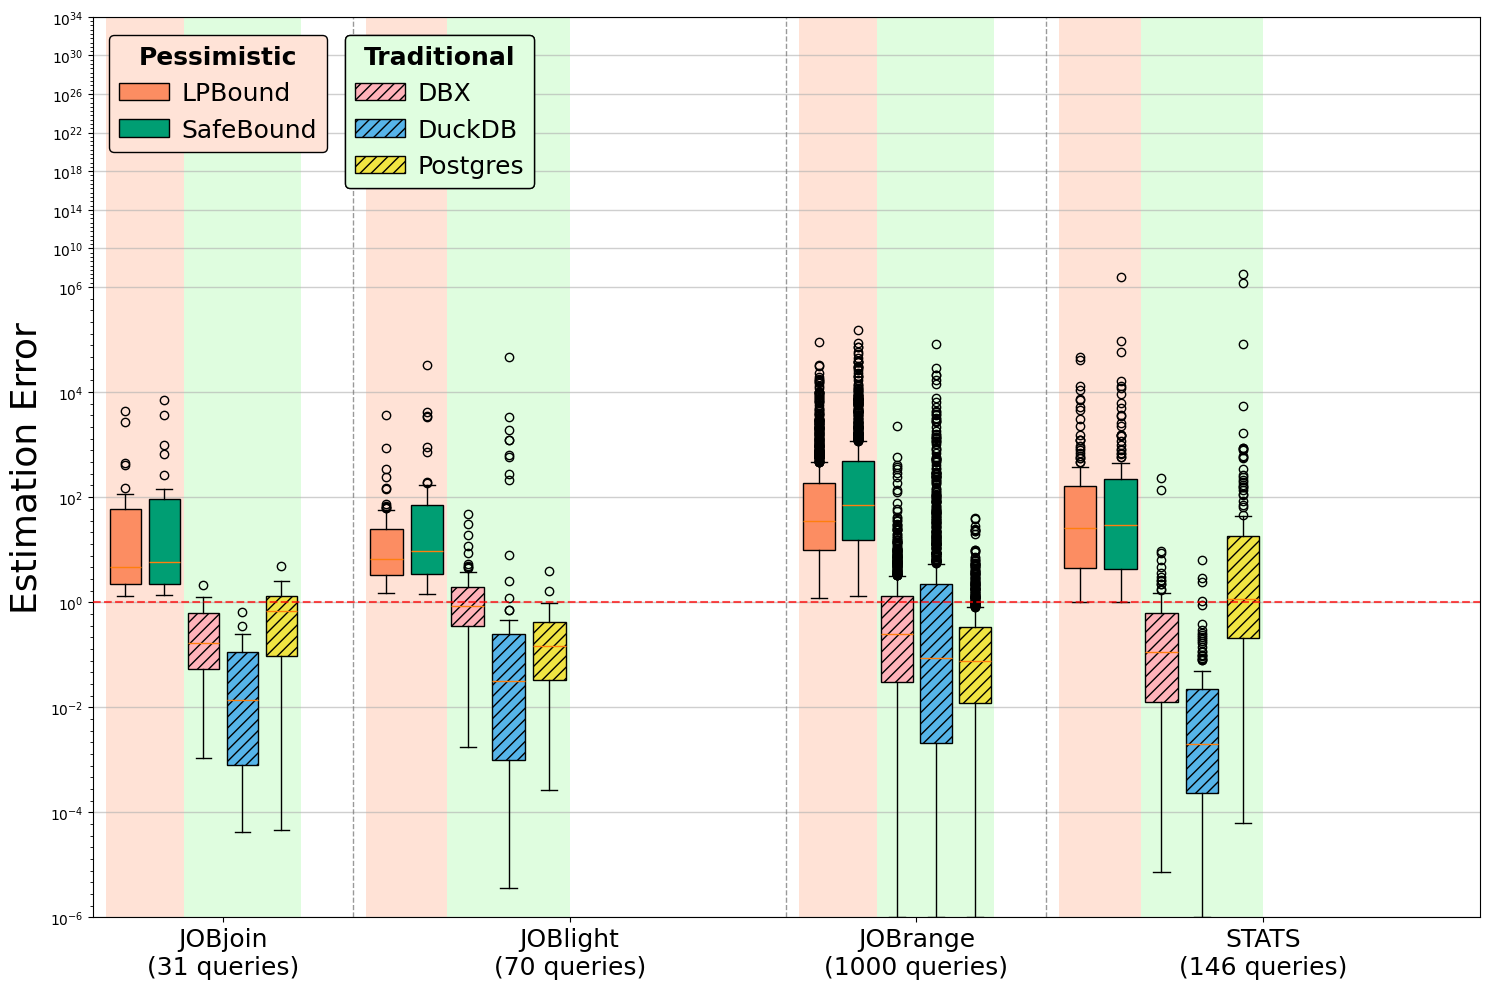

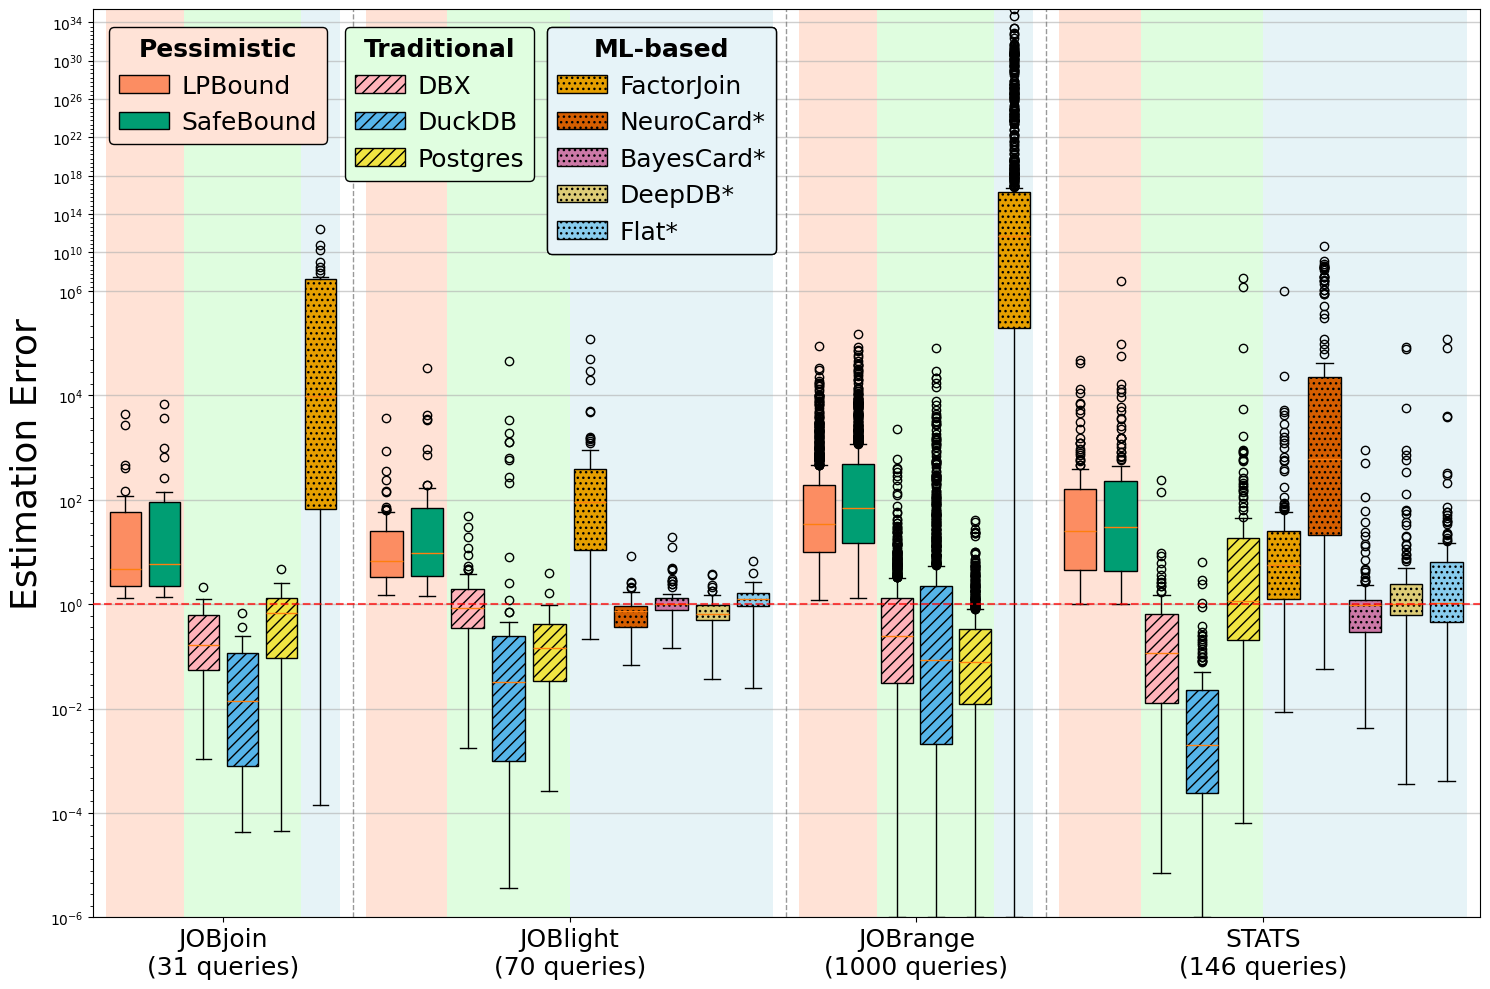

In [13]:
def draw_combined_trend_plot_sequence(dataframes, titles, methods_list, output_filename, 
                                    label_total_width=0.5, label_start_x=0.09, 
                                    draw_middle_line=False):
    # Get all unique methods across all benchmarks
    all_unique_methods = set(method for methods in methods_list for method in methods)
    
    # Define the sequence of method combinations
    pessimistic_methods = [m for m in categories['Pessimistic'] if m in all_unique_methods]
    traditional_methods = [m for m in categories['Traditional'] if m in all_unique_methods]
    ml_methods = [m for m in categories['ML-based'] if m in all_unique_methods]
    
    # Changed sequence order
    method_sequences = [
        ('Pessimistic Only', pessimistic_methods),
        ('Pessimistic + Traditional', pessimistic_methods + traditional_methods),
        ('All Methods', pessimistic_methods + traditional_methods + ml_methods)
    ]
    
    for sequence_name, sequence_methods in method_sequences:
        current_methods_list = []
        for methods in methods_list:
            current_methods = [m for m in methods if m in sequence_methods]
            current_methods_list.append(current_methods)
            
        draw_combined_trend_plot(
            dataframes=dataframes,
            titles=titles,
            methods_list=current_methods_list,
            all_possible_methods=methods_list,  # Pass the complete methods list for width calculations
            output_filename=f"{output_filename.replace('.pdf', '')}-{sequence_name.lower().replace(' ', '-')}.pdf",
            label_total_width=label_total_width,
            label_start_x=label_start_x,
            draw_middle_line=draw_middle_line
        )


# Usage:
df0, title0, methods0 = draw_full_estimates("jobjoin")
df1, title1, methods1 = draw_full_estimates("joblight")
df2, title2, methods2 = draw_full_estimates("jobrange")
df3, title3, methods3 = draw_full_estimates("stats")

draw_combined_trend_plot_sequence(
    [df0, df1, df2, df3], 
    [title0, title1, title2, title3], 
    [methods0, methods1, methods2, methods3], 
    "estimates_combined.pdf",
    label_total_width=0.5,
    label_start_x=0.09,
    draw_middle_line=False
)


# Breakdown of the estimation error for queries with different number of relations

In [6]:
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_trend_plot(df, title, methods, draw_ratio=False, show_all_group=True, output_filename="output.pdf", figsize=(20, 6), total_width=0.5, start_x=0.09, label_font_size=16):
    df = df[df["cardinality"] != 0]

    for method in methods:
        df.loc[:, f"{method}_error"] = df[method] / df["cardinality"]
    
    relation_counts = df["Relations"].value_counts().sort_index()

    fig, ax = plt.subplots(figsize=figsize)

    relations = sorted(df['Relations'].unique())
    if show_all_group:
        relations.insert(0, 'All')

    num_methods = len(methods)
    positions = range(len(relations))
    
    group_width = 0.8
    width = group_width / num_methods

    # Calculate the total width for all categories
    total_category_width = sum(len([m for m in cat_methods if m in methods]) for cat_methods in categories.values())
    category_start = 0

    for category, category_methods in categories.items():
        category_methods = [m for m in category_methods if m in methods]
        if not category_methods:
            continue

        category_width = len(category_methods) * width
        category_end = category_start + category_width

        # Draw category background
        for pos in positions:
            rect = patches.Rectangle((pos - group_width/2 + category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)

        for method in category_methods:
            if show_all_group:
                method_data = [df[f"{method}_error"]]
                method_data.extend([df[df['Relations'] == rel][f"{method}_error"] for rel in relations[1:]])
            else:
                method_data = [df[df['Relations'] == rel][f"{method}_error"] for rel in relations]
            
            method_index = methods.index(method)
            box_positions = [p + (method_index - num_methods/2 + 0.5) * width for p in positions]
            bp = ax.boxplot(method_data, 
                            positions=box_positions, 
                            widths=width, patch_artist=True)
            
            color = ESTIMATOR_COLORS[method_names[method]]
            pattern = category_patterns[category]
            for patch in bp['boxes']:
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
                patch.set_hatch(pattern)

        category_start = category_end

    if show_all_group:
        x_labels = [f"All\n({len(df)} queries)"]
        x_labels.extend([f"{rel}\n({relation_counts.get(rel, 0)} queries)" for rel in relations[1:]])
    else:
        x_labels = [f"{rel}\n({relation_counts.get(rel, 0)} queries)" for rel in relations]

    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels)

    if show_all_group:
        ax.get_xticklabels()[0].set_fontweight('bold')
        ax.get_xticklabels()[0].set_fontsize(18)

    plt.xlabel("Number of relations in query", fontsize=18)
    plt.ylabel("Estimation Error", fontsize=18)
    
    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        # total_width = 0.35  # Total width for all legend boxes
        box_width = total_width / len(filtered_categories)
        # start_x = 0.7  # Adjust as needed

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            
            for method in category_methods:
                if method in methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            bbox_to_anchor=(start_x + i * box_width, 1),  # Adjust positioning
                            bbox_transform=ax.transAxes,
                            fontsize=label_font_size,
                            title_fontsize=label_font_size,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)

    plt.yscale("log")

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # set title 
    plt.title(title, fontsize=18)

    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))

    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=1.0, alpha=0.5)

    for x in range(len(relations) - 1):
        ax.axvline(x + 0.5, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    ax.set_xlim(-0.5, len(relations) - 0.5)

    if show_all_group:
        ax.axvspan(-0.5, 0.5, facecolor='lightblue', alpha=0.3, zorder=-1)

    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    
    # create plots dir if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close(fig)



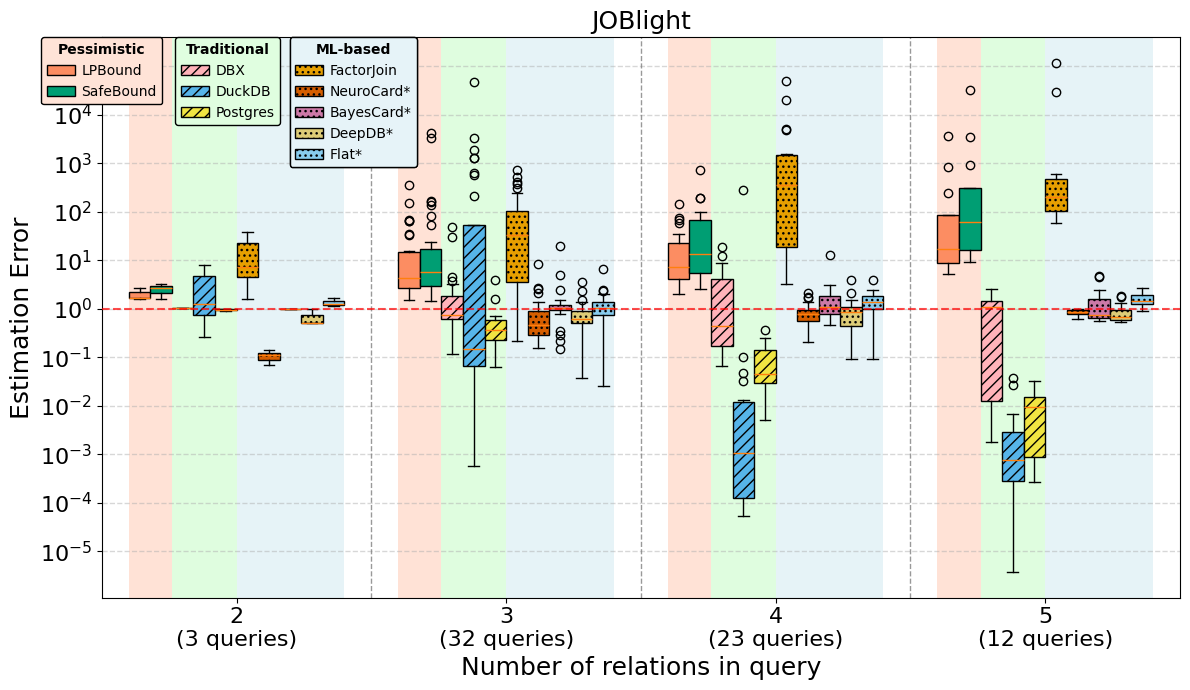

In [7]:
_df, _title, _methods = draw_full_estimates("joblight")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7), total_width=0.35, start_x=0.00, label_font_size=10)

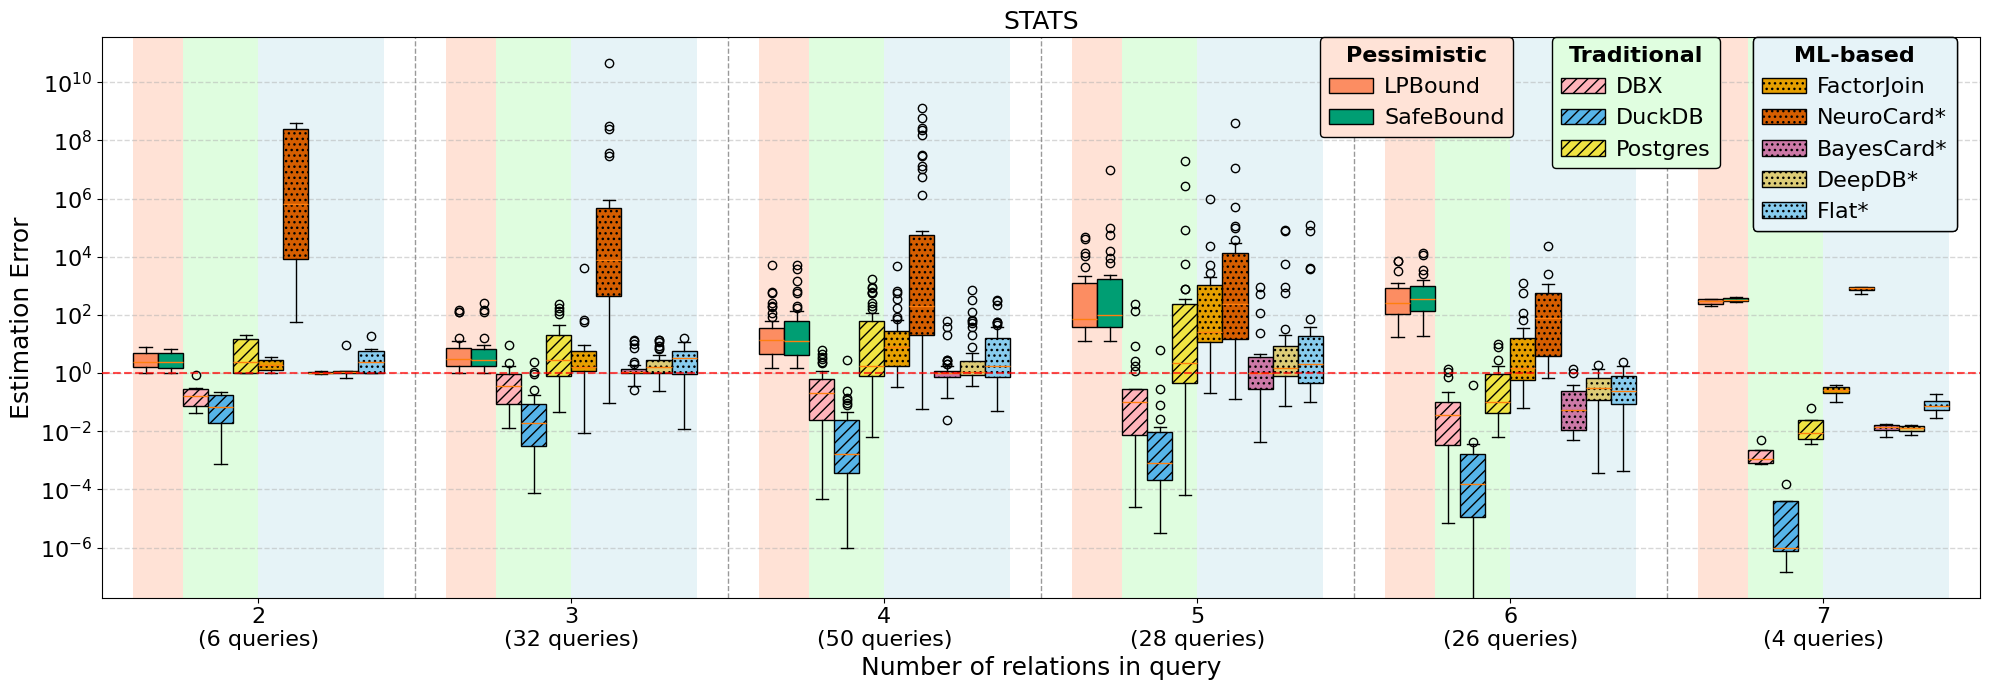

In [8]:
_df, _title, _methods = draw_full_estimates("stats")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7), total_width=0.35, start_x=0.7)

File ../results/accuracy_acyclic/jobrange/neurocard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/bayescard_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/deepdb_jobrange_full_estimations.csv does not exist
File ../results/accuracy_acyclic/jobrange/flat_jobrange_full_estimations.csv does not exist


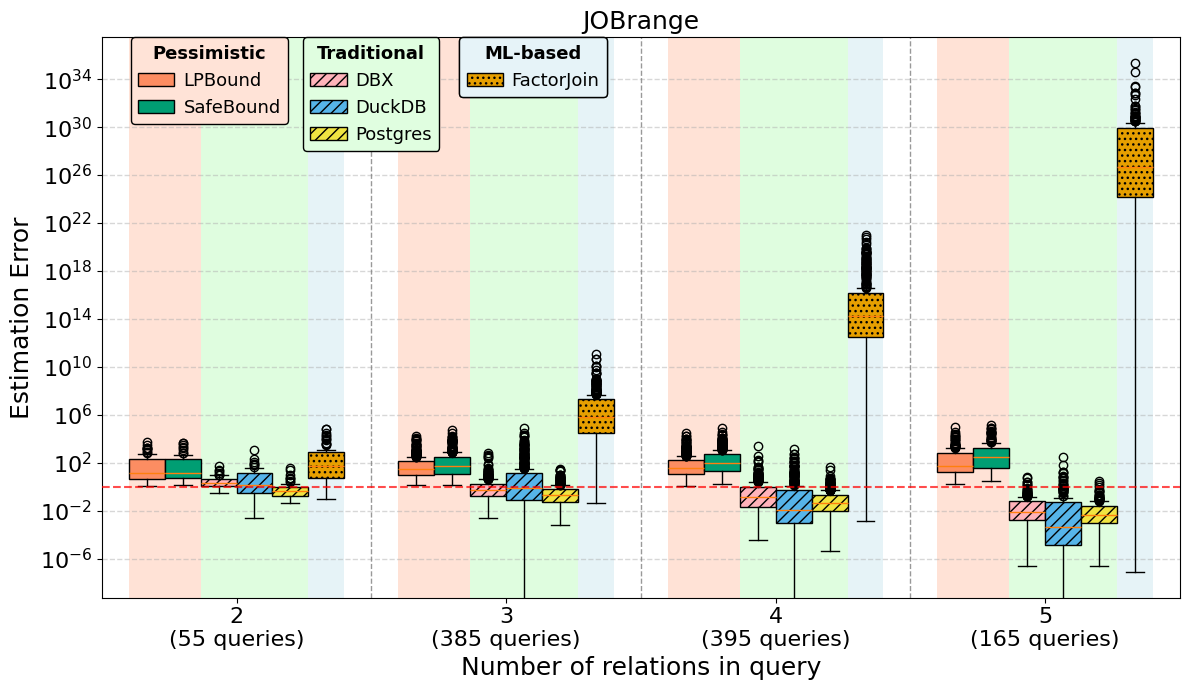

In [9]:
_df, _title, _methods = draw_full_estimates("jobrange")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7), total_width=0.45, start_x=0.10, label_font_size=13)

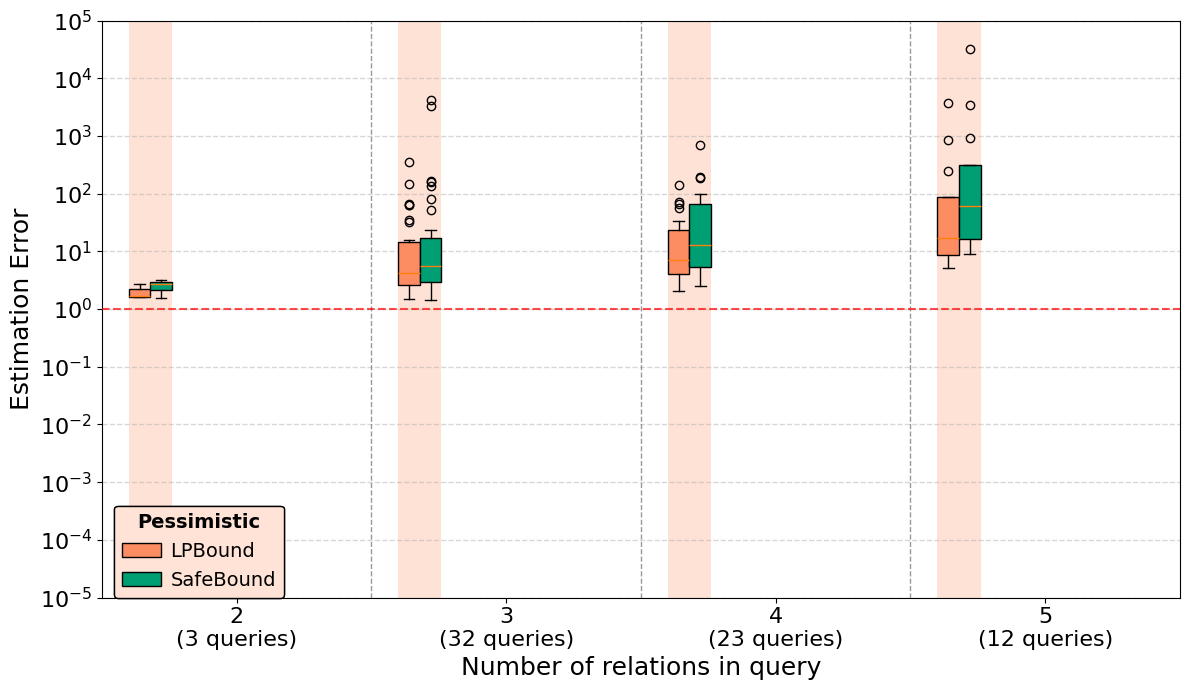

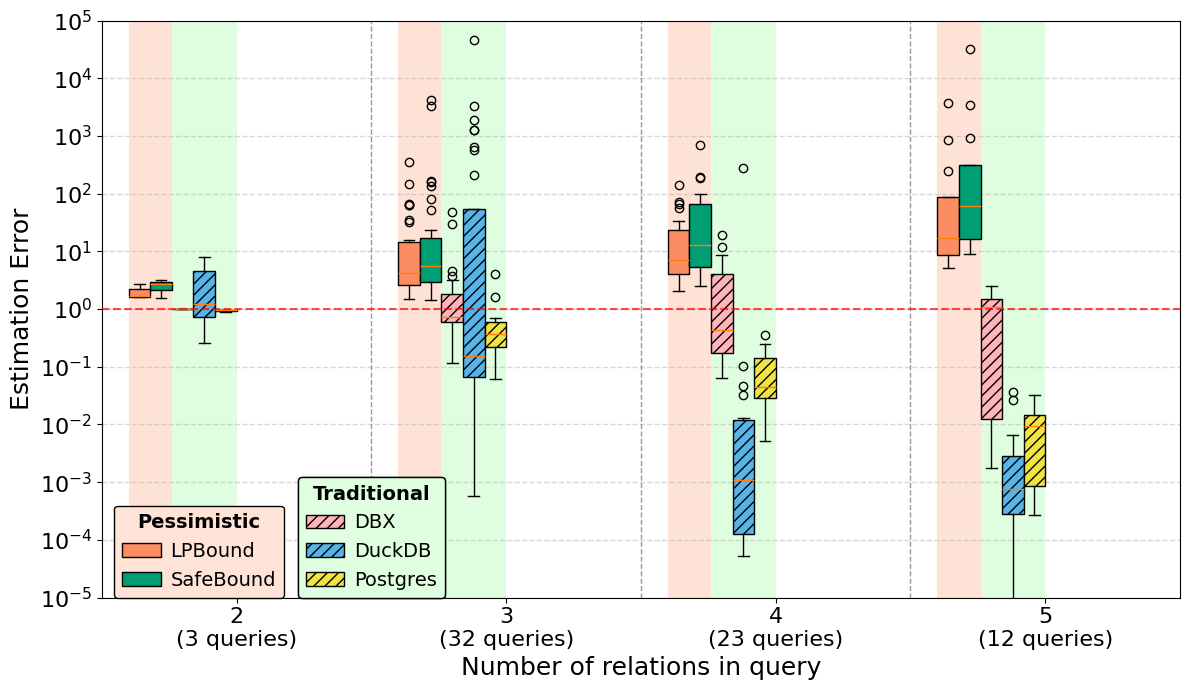

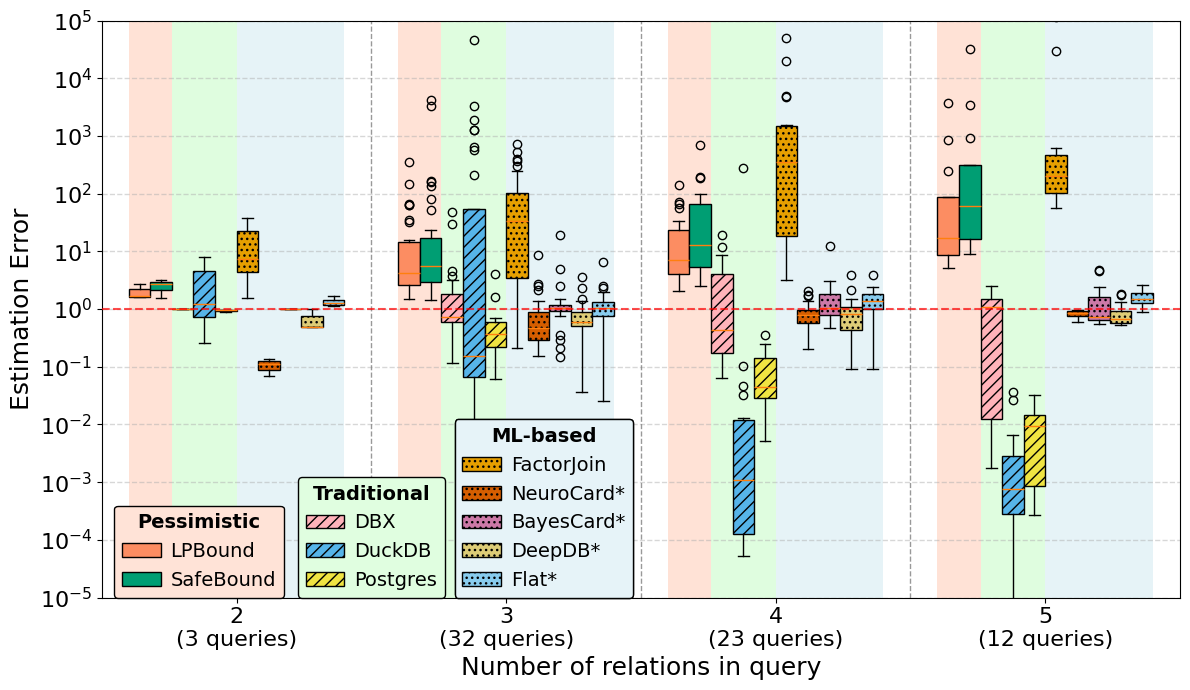

In [25]:
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_trend_plot_sequence(df, title, all_methods, draw_ratio=False, show_all_group=False, 
                           output_filename="output.pdf", figsize=(12, 7), total_width=0.35, 
                           start_x=0.00, label_font_size=10):
    
    # Get methods by category in order
    traditional_methods = [m for m in categories['Traditional'] if m in all_methods]
    pessimistic_methods = [m for m in categories['Pessimistic'] if m in all_methods]
    ml_methods = [m for m in categories['ML-based'] if m in all_methods]
    # 
    # method_sequences = [
    #     ('Traditional Only', traditional_methods),
    #     ('Traditional + Pessimistic', traditional_methods + pessimistic_methods),
    #     ('All Methods', traditional_methods + pessimistic_methods + ml_methods)
    # ]

    method_sequences = [
        ('Pessimistic Only', pessimistic_methods),
        ('Traditional + Pessimistic', traditional_methods + pessimistic_methods),
        ('All Methods', traditional_methods + pessimistic_methods + ml_methods)
    ]

    def modified_draw_trend_plot(df, title, methods, total_methods, **kwargs):
        df = df[df["cardinality"] != 0]

        for method in methods:
            df.loc[:, f"{method}_error"] = df[method] / df["cardinality"]
        
        relation_counts = df["Relations"].value_counts().sort_index()

        fig, ax = plt.subplots(figsize=kwargs.get('figsize', (20, 6)))

        relations = sorted(df['Relations'].unique())
        if kwargs.get('show_all_group', True):
            relations.insert(0, 'All')

        num_methods = len(total_methods)
        positions = range(len(relations))
        
        group_width = 0.8
        width = group_width / num_methods

        # Calculate fixed positions for each category
        fixed_category_order = ['Pessimistic', 'Traditional', 'ML-based']
        category_positions = {}
        current_pos = 0
        
        # Calculate method positions
        method_positions = {m: i for i, m in enumerate(total_methods)}

        # Calculate fixed start positions for each category
        for cat in fixed_category_order:
            category_methods = [m for m in categories[cat] if m in total_methods]
            category_positions[cat] = current_pos
            current_pos += len(category_methods) * width

        # Now draw categories in their fixed positions
        for category in fixed_category_order:
            category_methods = [m for m in categories[category] if m in methods]
            if not category_methods:
                continue

            category_width = len([m for m in categories[category] if m in total_methods]) * width
            category_start = category_positions[category]

            # Draw category background
            for pos in positions:
                rect = patches.Rectangle(
                    (pos - group_width/2 + category_start, 0), 
                    category_width, 1, 
                    fill=True, 
                    facecolor=category_colors[category], 
                    alpha=0.3, 
                    transform=ax.get_xaxis_transform(), 
                    zorder=0
                )
                ax.add_patch(rect)

            for method in category_methods:
                if kwargs.get('show_all_group', True):
                    method_data = [df[f"{method}_error"]]
                    method_data.extend([df[df['Relations'] == rel][f"{method}_error"] 
                                     for rel in relations[1:]])
                else:
                    method_data = [df[df['Relations'] == rel][f"{method}_error"] 
                                 for rel in relations]
                
                method_position = method_positions[method]
                box_positions = [p + (method_position - num_methods/2 + 0.5) * width 
                               for p in positions]
                
                bp = ax.boxplot(method_data, 
                              positions=box_positions, 
                              widths=width, 
                              patch_artist=True)
                
                color = ESTIMATOR_COLORS[method_names[method]]
                pattern = category_patterns[category]
                for patch in bp['boxes']:
                    patch.set_facecolor(color)
                    patch.set_edgecolor('black')
                    patch.set_hatch(pattern)

        if kwargs.get('show_all_group', True):
            x_labels = [f"All\n({len(df)} queries)"]
            x_labels.extend([f"{rel}\n({relation_counts.get(rel, 0)} queries)" for rel in relations[1:]])
        else:
            x_labels = [f"{rel}\n({relation_counts.get(rel, 0)} queries)" for rel in relations]

        ax.set_xticks(positions)
        ax.set_xticklabels(x_labels)

        if kwargs.get('show_all_group', True):
            ax.get_xticklabels()[0].set_fontweight('bold')
            ax.get_xticklabels()[0].set_fontsize(18)

        plt.xlabel("Number of relations in query", fontsize=18)
        plt.ylabel("Estimation Error", fontsize=18)
        
        # Create legends
        filtered_categories = []
        for category in fixed_category_order:
            present_methods = [method for method in categories[category] if method in methods]
            if present_methods:
                filtered_categories.append((category, present_methods))

        if filtered_categories:
            legends = []
            box_width = 0.16
            
            for i, (category, category_methods) in enumerate(filtered_categories):
                legend_elements = []
                legend_labels = []
                
                pattern = category_patterns[category]
                
                for method in category_methods:
                    if method in methods:
                        color = ESTIMATOR_COLORS[method_names[method]]
                        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, 
                                                      edgecolor='black', hatch=pattern))
                        legend_labels.append(method_names[method])
                
                legend = ax.legend(legend_elements, legend_labels,
                                title=category,
                                loc='lower center',
                                bbox_to_anchor=(kwargs.get('start_x', 0.09) + i * box_width, 0),
                                bbox_transform=ax.transAxes,
                                fontsize=kwargs.get('label_font_size', 16),
                                title_fontsize=kwargs.get('label_font_size', 16),
                                frameon=True,
                                edgecolor='black',
                                borderaxespad=0,
                                handletextpad=0.5,
                                columnspacing=1.0)
                
                legend.get_title().set_fontweight('bold')
                frame = legend.get_frame()
                lightened_color = lighten_color(category_colors[category], amount=0.3)
                frame.set_facecolor(lightened_color)
                frame.set_alpha(1.0)
                
                legends.append(legend)
            
            for legend in legends:
                ax.add_artist(legend)

        ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)

        plt.yscale("log")
        ax.set_ylim(1e-5, 1e5)
        yticks = [10**i for i in range(-5, 6)]
        ax.set_yticks(yticks)
        ax.set_yticklabels(['$10^{%d}$' % i for i in range(-5, 6)])

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # plt.title(title, fontsize=18)

        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=10))
        ax.yaxis.grid(True, which='both', linestyle='--', linewidth=1.0, alpha=0.5)

        for x in range(len(relations) - 1):
            ax.axvline(x + 0.5, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
        
        ax.set_xlim(-0.5, len(relations) - 0.5)

        if kwargs.get('show_all_group', True):
            ax.axvspan(-0.5, 0.5, facecolor='lightblue', alpha=0.3, zorder=-1)

        ax.set_axisbelow(True)

        plt.tight_layout()
        fig.canvas.draw()
        
        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig(f"plots/{kwargs.get('output_filename', 'output.pdf')}", 
                   format='pdf', dpi=300, bbox_inches='tight')
        
        plt.show()
        plt.close(fig)

    # Generate plots for each sequence
    for sequence_name, methods in method_sequences:
        modified_draw_trend_plot(
            df=df,
            title=f"{title}\n({sequence_name})",
            methods=methods,
            total_methods=all_methods,
            draw_ratio=draw_ratio,
            show_all_group=show_all_group,
            output_filename=f"{output_filename.replace('.pdf', '')}-{sequence_name.lower().replace(' ', '-')}.pdf",
            figsize=figsize,
            total_width=total_width,
            start_x=start_x,
            label_font_size=label_font_size
        )

# Usage
_df, _title, _methods = draw_full_estimates("joblight")
draw_trend_plot_sequence(
    _df, _title, _methods,
    draw_ratio=False,
    show_all_group=False,
    output_filename="estimates-joblight.pdf",
    figsize=(12, 7),
    total_width=0.35,
    start_x=0.09,
    label_font_size=14
)



# Groupby Queries

## Postgres Groupby Estimation 

Group-by variables in a single relation |R|:
- one variable: the estimated domain size of the variable
- multiple Variables: the product of the domain sizes
- capped at the cardinality |R| of the relation (capped at |R|/10 if there are multiple variables)
- adjusts the estimation based on the selectivity of filter conditions

Group-by variables in multiple relations:
- compute the sizes in single relations as above
- multiply them together
- **capped at the CE of the full join**

Conclusion:
    min(product of the domain sizes, CE of the full join)

## Groupby Queries Generation:

- For each relation, extract its categorical variables and divide them into those with large domain sizes (>150) and those with small domain sizes (<=150). 
- For each full query in the original benchmarks, we create a new query by adding categorical variables as group-by variables.
    - A categorical variable is considered for addition as a group-by variable if it is not a join variable and is not a predicate variable 
    - Add at most one group-by variable to each relation
    - Sometimes a relation does not have a group-by variable since it does not have any categorical variables that are not join variables or predicate variables
- Queries with true cardinality = 0 are removed
- We create three versions of the query: 
    - the query with group-by variables with small domain sizes
    - the query with group-by variables with large domain sizes
    - the query with group-by variables with both small and large domain sizes

In [10]:
groupby_benchmark_names = {
    "joblight": "JOBl",
    "stats": "STATS",
    "jobrange": "JOBr",
}
query_set_names = {
    "small": "sm",
    "large": "lg",
    "mixed": "mix",
}

In [11]:

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_combined_trend_plot(dataframes, titles, methods_list, output_filename, label_total_width=0.5, label_start_x=0.09, draw_middle_line=False):
    fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size

    num_dfs = len(dataframes)
    
    all_methods = set(method for methods in methods_list for method in methods)

    # Calculate the width for each benchmark based on its number of methods
    benchmark_widths = [len(methods) for methods in methods_list]
    total_methods = sum(benchmark_widths)
    total_width = 0.9 * num_dfs  # Increased total width to reduce margins
    width_per_method = total_width / total_methods

    # Calculate fixed_width and padding
    fixed_width = width_per_method * 0.8  # 80% of width_per_method for each box
    benchmark_padding = width_per_method * 0.3  # 20% of width_per_method for padding

    # Calculate positions for each benchmark
    positions = []
    benchmark_starts = [0]
    current_pos = 0
    gap = 0  # Adjust this value to increase or decrease the gap between benchmarks
    for width in benchmark_widths:
        benchmark_width = width * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap  # Add the gap after each benchmark
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, (df, methods) in enumerate(zip(dataframes, methods_list)):
        benchmark_start = benchmark_starts[i]
        benchmark_width = benchmark_starts[i+1] - benchmark_start
        usable_width = benchmark_width - 2 * benchmark_padding
        
        present_categories = [cat for cat, cat_methods in categories.items() if any(m in methods for m in cat_methods)]
        
        # Calculate the total number of methods across all categories
        total_methods_in_benchmark = sum(len([m for m in categories[cat] if m in methods]) for cat in present_categories)
        
        # Calculate the width for each box
        box_width = usable_width / total_methods_in_benchmark
        
        category_start = benchmark_start + benchmark_padding
        for category in present_categories:
            category_methods = [m for m in categories[category] if m in methods]
            category_width = len(category_methods) * box_width
            
            # Draw category background
            rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)
            
            # Position boxes within the category
            for k, method in enumerate(category_methods):
                if method in all_methods:
                    df_filtered = df[df["cardinality"] != 0]
                    df_filtered.loc[:, f"{method}_error"] = df_filtered[method] / df_filtered["cardinality"]
                    method_data = df_filtered[f"{method}_error"]
                    
                    box_pos = category_start + (k + 0.5) * box_width
                    bp = ax.boxplot([method_data], 
                                    positions=[box_pos], 
                                    widths=box_width * 0.8,
                                    patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Set x-axis ticks and labels
    ax.set_xticks(positions)
    
    x_labels = [f"{title}\n({len(df)} queries)" for df, title in zip(dataframes, titles)]
    ax.set_xticklabels(x_labels)

    for label in ax.get_xticklabels():
        # label.set_fontweight('bold')
        label.set_fontsize(18)

    plt.ylabel("Estimation Error", fontsize=26)
    # x_label_text = "# edge relations in query (# queries)" if not draw_middle_line else "Benchmark (# queries)"
    # plt.xlabel(x_label_text, fontsize=22)
    
    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in all_methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        total_width = label_total_width
        box_width = total_width / len(filtered_categories)
        # start_x = 0.5 - total_width / 2  # Center the group of legends
        start_x = label_start_x

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            # legend_elements.append(Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black', hatch=pattern))
            # legend_labels.append(category)
            
            for method in category_methods:
                if method in all_methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            bbox_to_anchor=(start_x + i * box_width, 0.98),  # Adjust positioning
                            bbox_transform=ax.transAxes,
                            fontsize=18,
                            title_fontsize=18,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)  # Adjust amount as needed
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)  # Ensure the background is fully opaque
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)

    plt.yscale("log")

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=20)

    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=1.0, alpha=0.5)

    # Add vertical lines between benchmarks
    for end in benchmark_starts[1:-1]:
        ax.axvline(end, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Add a very visible vertical line in the middle
    # this is a hack to separate the two groups of benchmarks
    # in this scenario, we have six groups of benchmarks. I want to separate the first three from the last three
    if draw_middle_line:
        ax.axvline(benchmark_starts[3], color='black', linestyle='--', linewidth=2.5, alpha=0.9)
    
    # Adjust x-axis limits to reduce margins
    ax.set_xlim(0, benchmark_starts[-1])

    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    

    os.makedirs('plots', exist_ok=True)
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [12]:
def draw_groupby_estimates(benchmark="joblight", query_set="small"):
    """query_set: small, large, mixed"""

    methods = [
        "lpbound",
        "safebound",
        "dbx",
        "duckdb",
        "postgres",
        "postgresfull"
    ]

    overall_df = pd.DataFrame() 
    for method in methods:
        file = f"../results/accuracy_groupby/{benchmark}/{method}_{benchmark}_groupby_{query_set}_estimations.csv"
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        df = pd.read_csv(file)
        if "QueryID" not in overall_df:
            overall_df["QueryID"] = df["QueryID"]
        else:
            assert (overall_df["QueryID"] == df["QueryID"]).all()
        
        overall_df[method] = df[f"{method}_Estimate"]
        
    
    # read the true cardinality
    df = pd.read_csv(f"../results/accuracy_groupby/{benchmark}/truecardinality_{benchmark}_groupby_{query_set}_estimations.csv")
    overall_df["cardinality"] = df["truecardinality_Estimate"]

    # read the relation counts
    df = pd.read_csv(f"../workloads/{benchmark}_gby/{benchmark}_groupby_{query_set}_relation_counts.csv")
    overall_df["Relations"] = df["Relations"]

    this_title = f"{groupby_benchmark_names[benchmark]}-{query_set_names[query_set]}"

    return overall_df, this_title, methods

# 


## Figure 7: Estimation errors for group-by queries

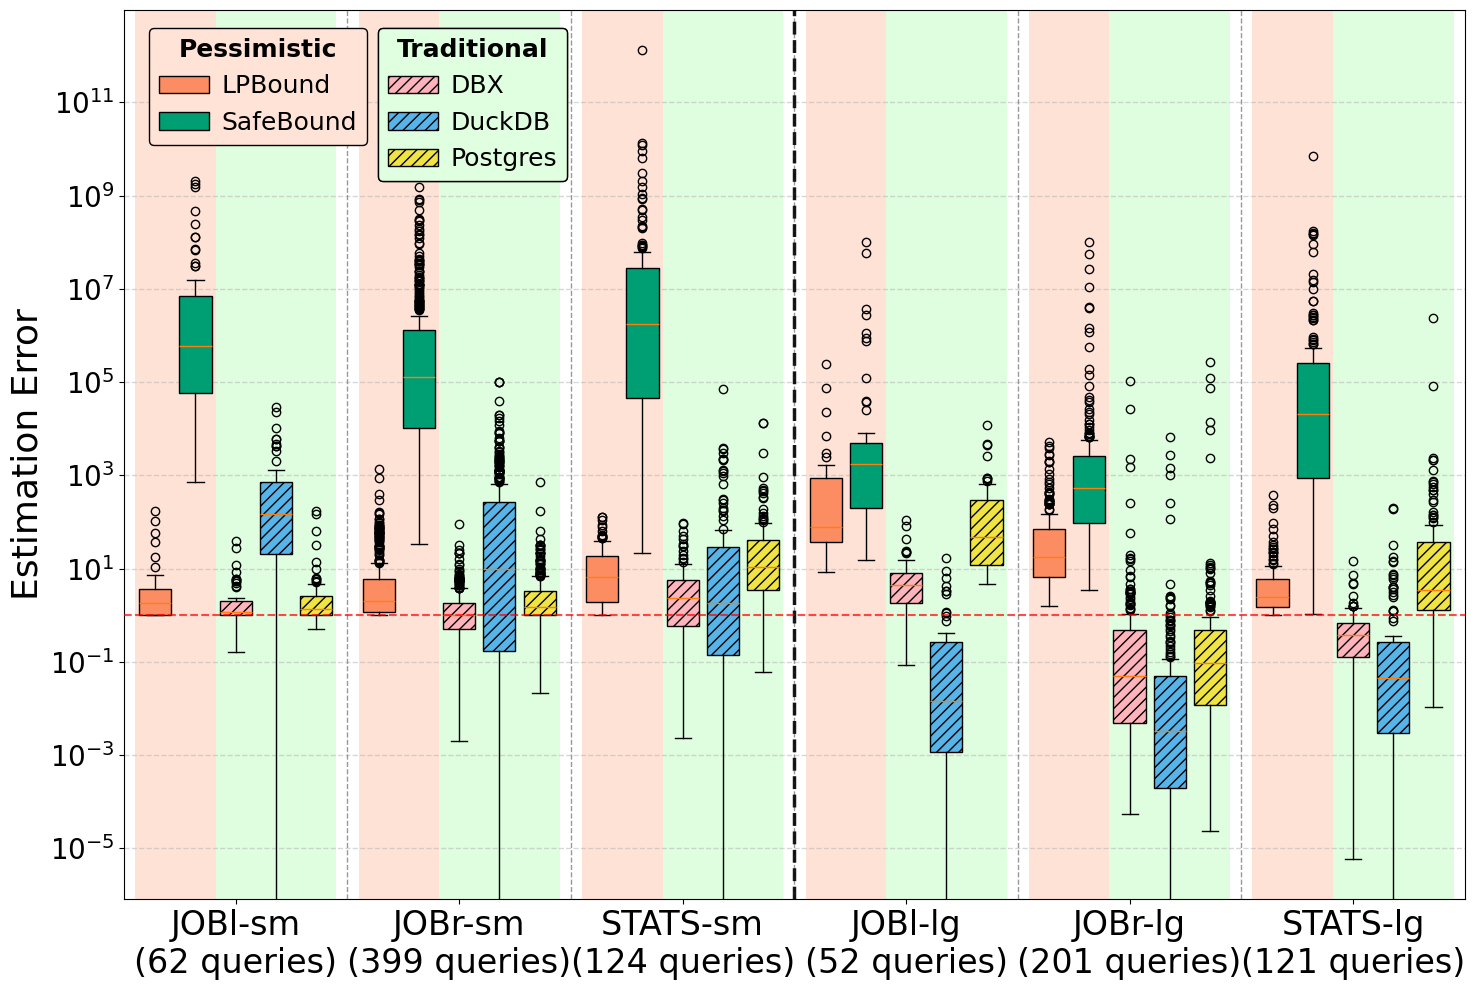

In [13]:
dfs = []
titles = []
methods = []
for query_set in ["small", "large"]: # small domain
    for benchmark in ["joblight", "jobrange", "stats"]:
        df, title, method = draw_groupby_estimates(benchmark, query_set)
        dfs.append(df)
        titles.append(title)
        methods.append(method)
draw_combined_trend_plot(dfs, titles, methods, "groupby_estimates_combined.pdf", label_total_width=0.32, label_start_x=0.1, draw_middle_line=True)

# Breakdown of the estimation error for group-by queries with different number of relations

In [14]:
benchmarks = ["joblight", "jobrange", "stats"]

## Small Domain Sizes

- LpBound and psql use the product of the domain sizes of the group-by variables as the cardinality estimation. They are accurate.
- DuckDB uses the CE of the full join thus overestimates the cardinality.


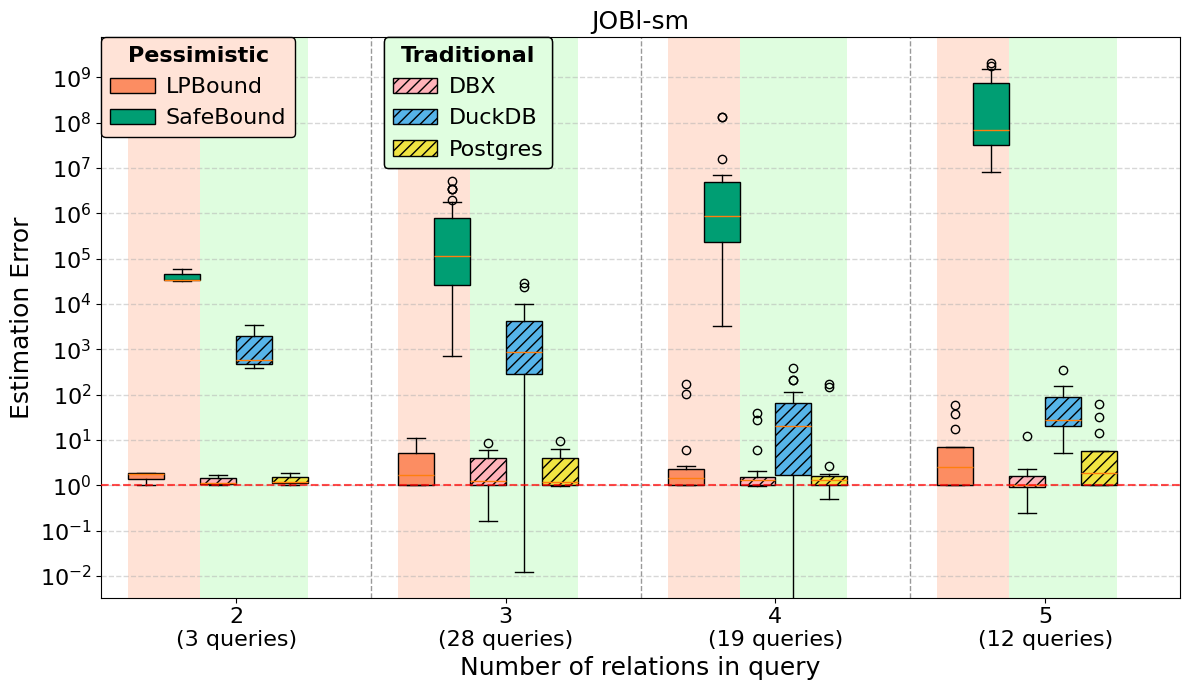

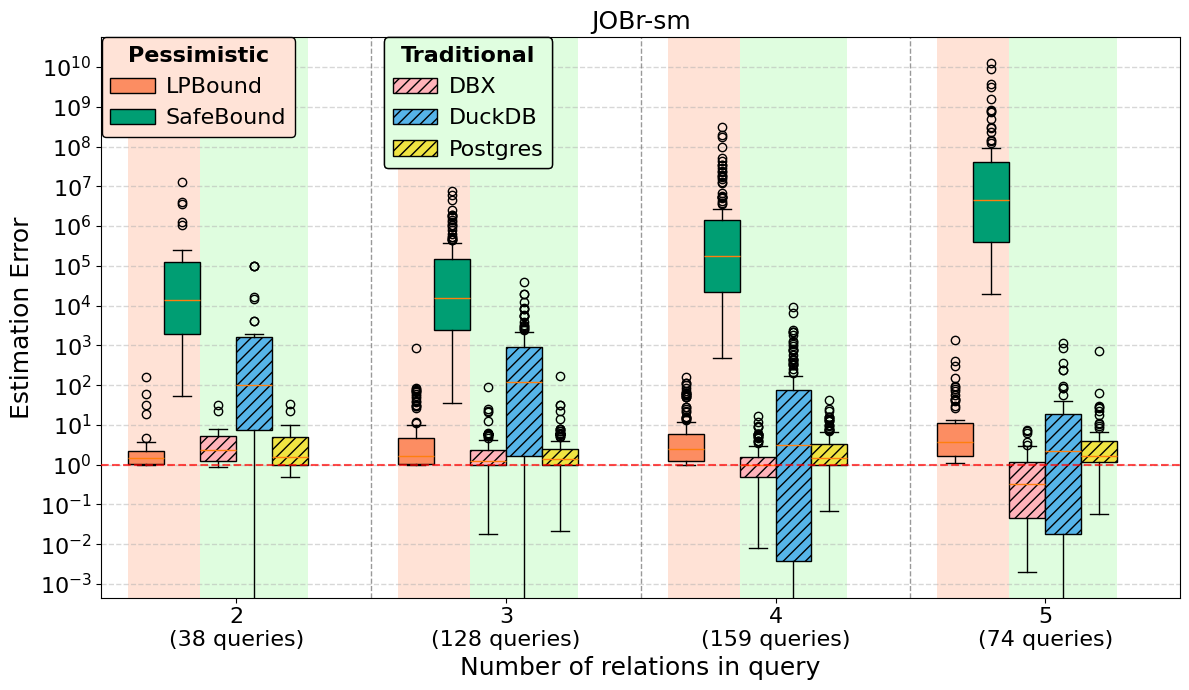

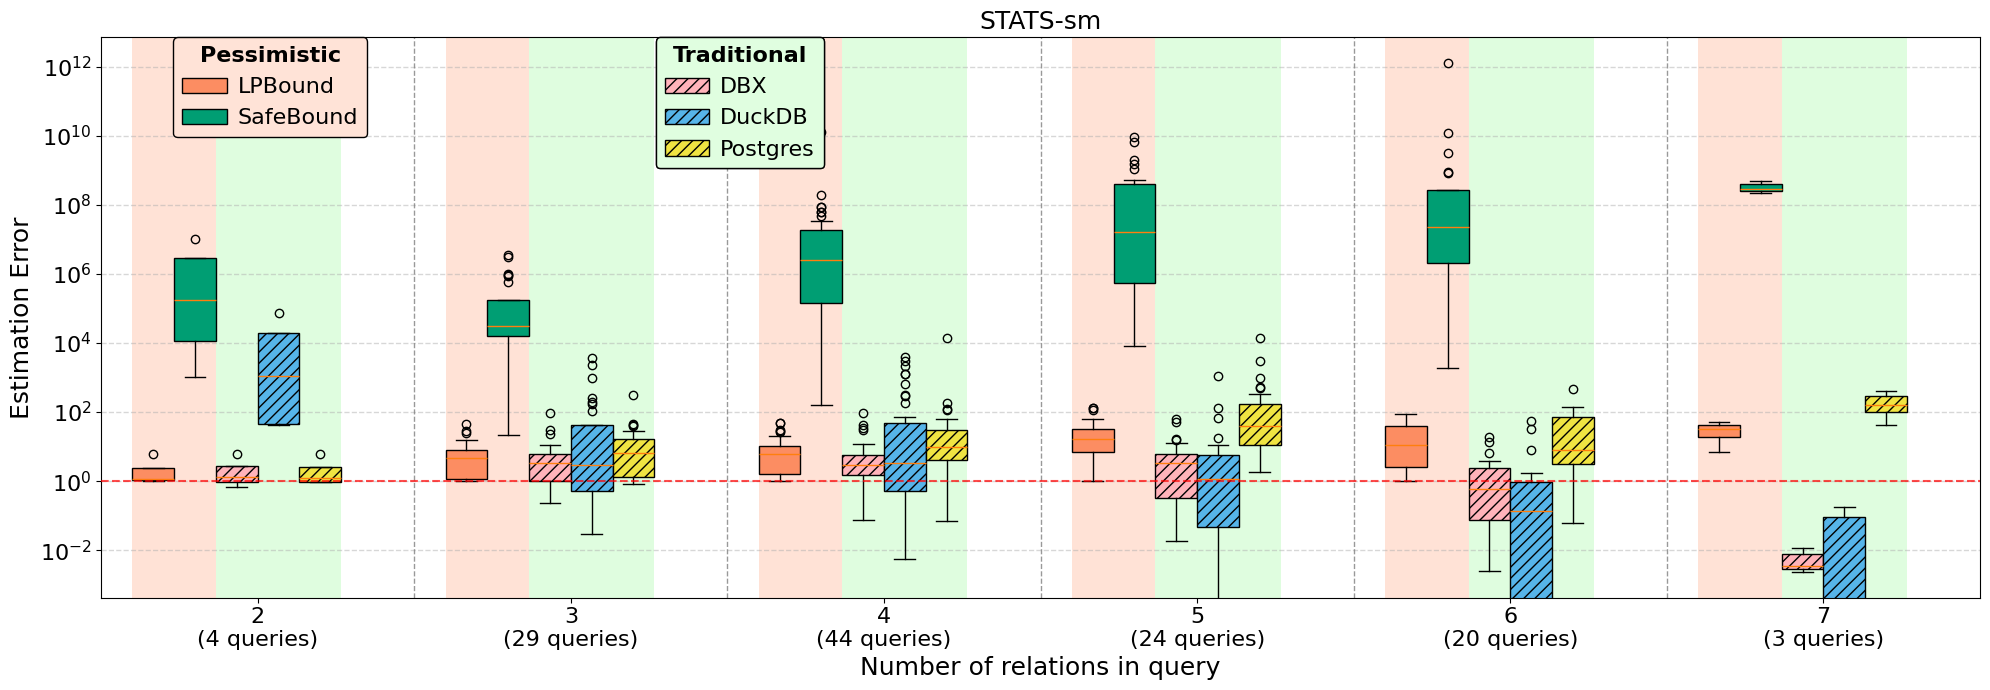

In [15]:
_df, _title, _methods = draw_groupby_estimates("joblight", "small")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "small")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "small")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))

## Large Domain Sizes

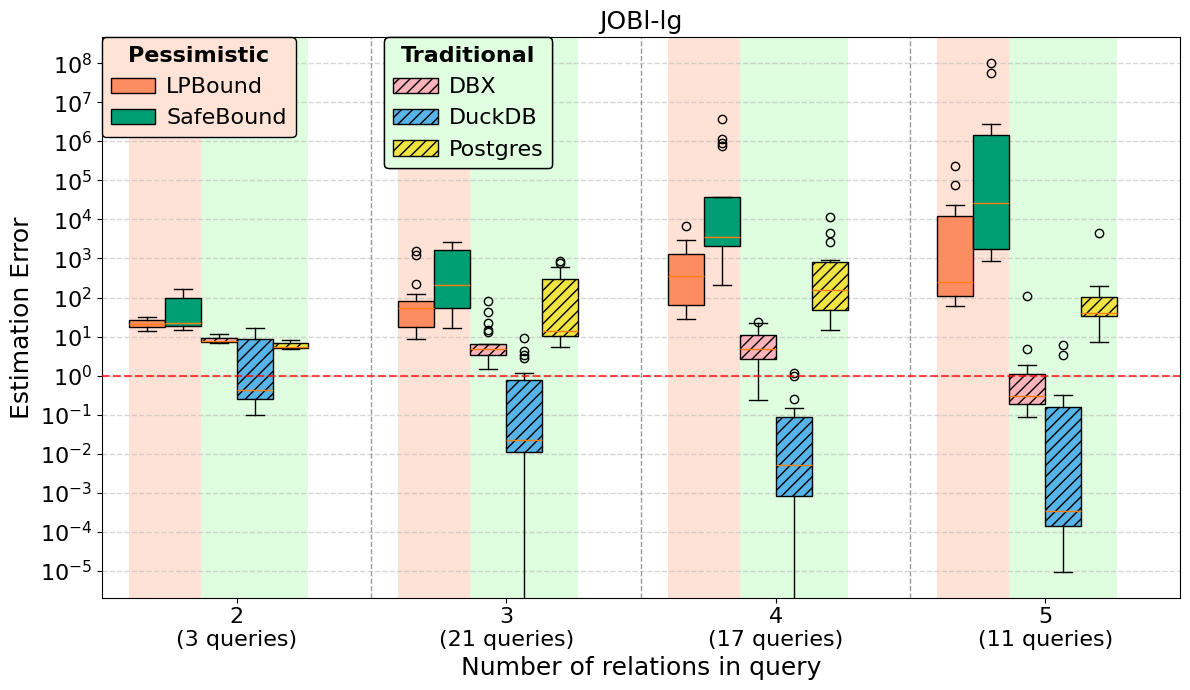

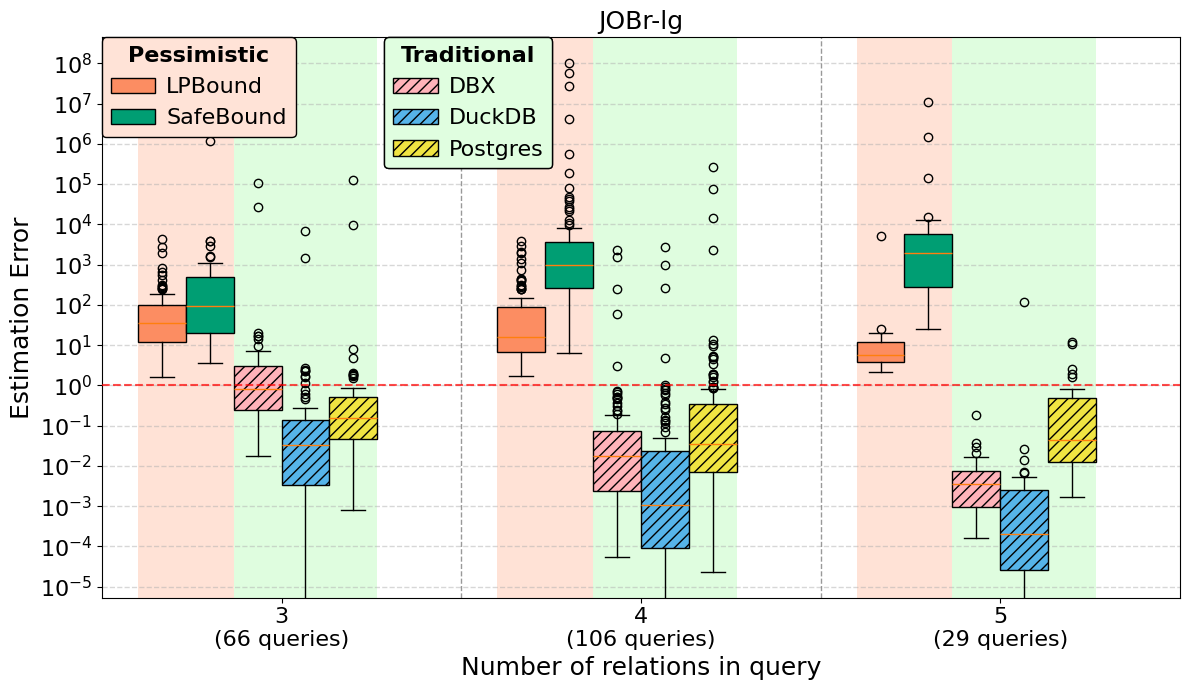

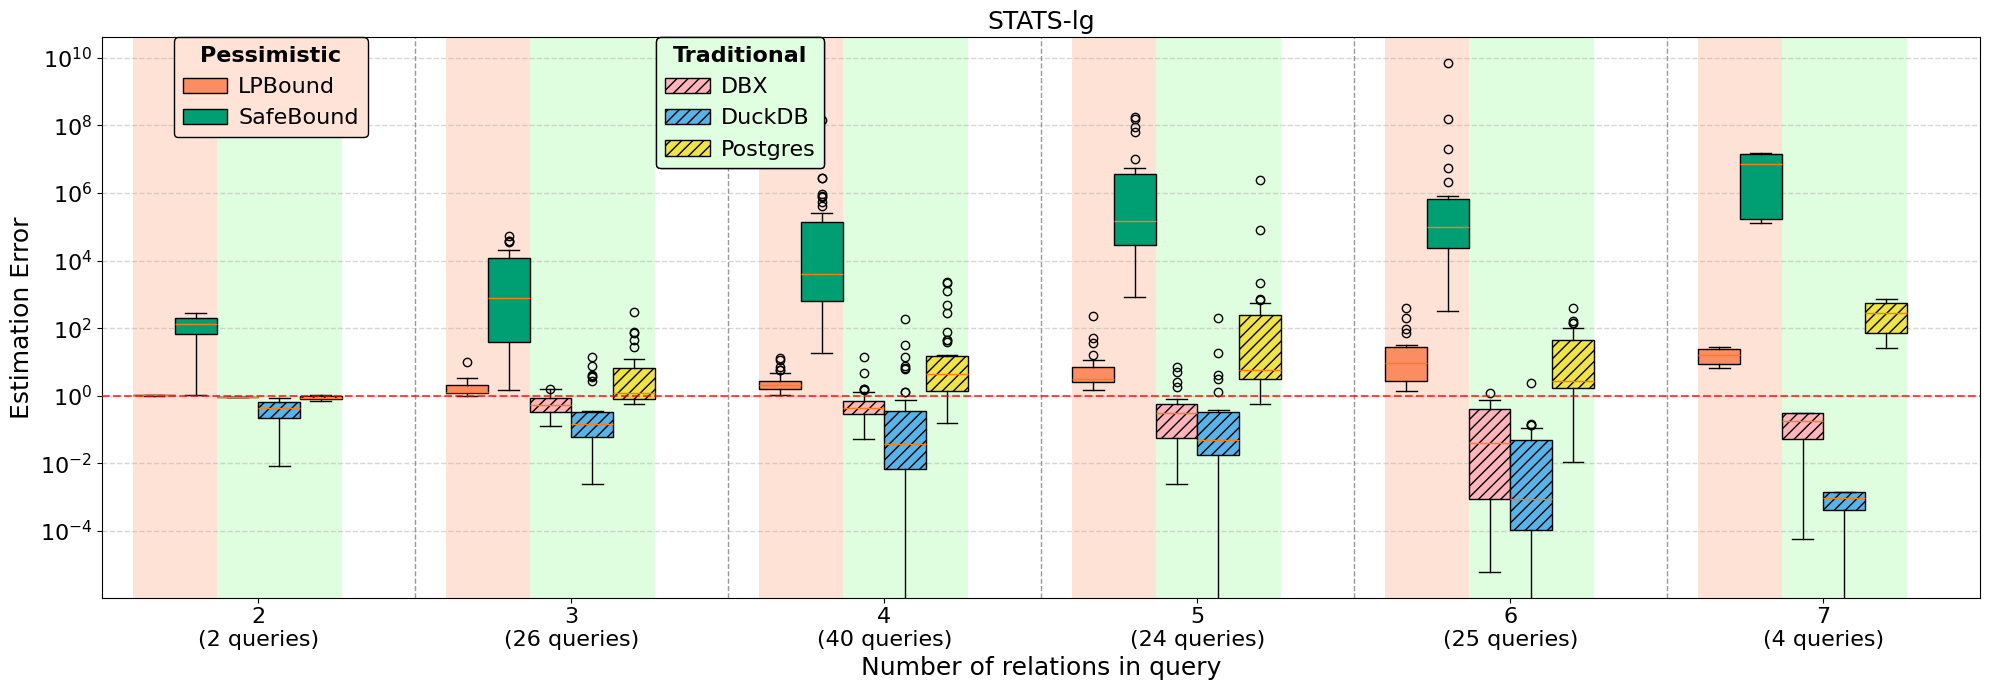

In [16]:
_df, _title, _methods = draw_groupby_estimates("joblight", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))

## Mixed Domain Sizes

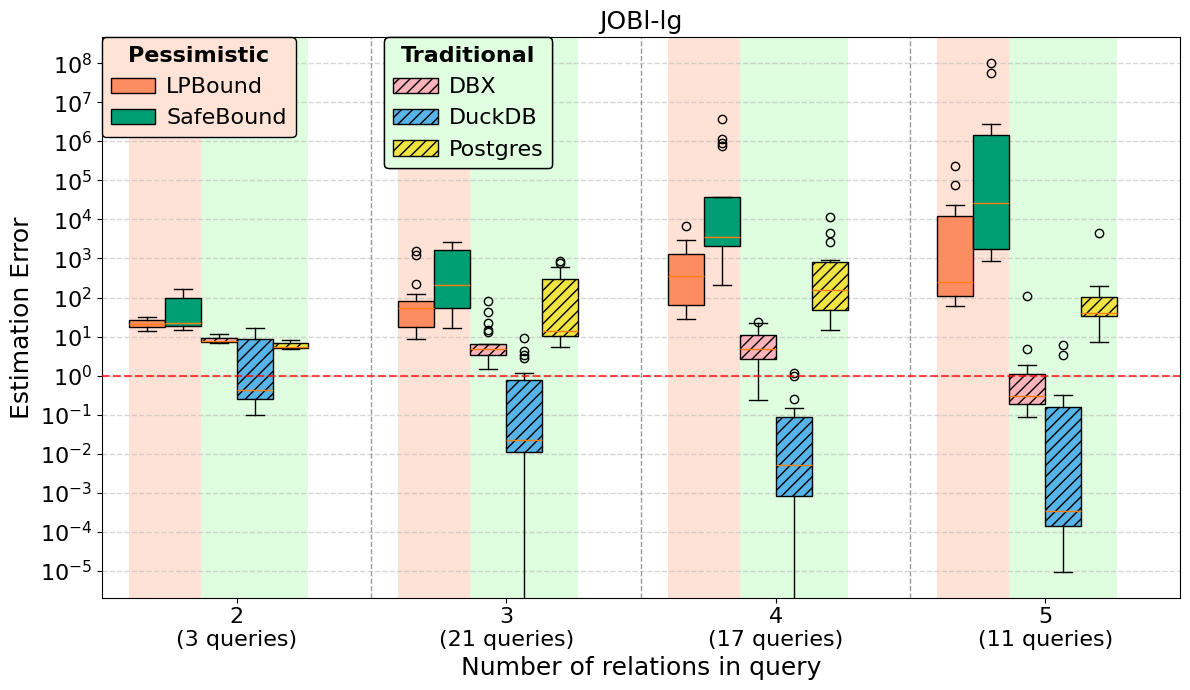

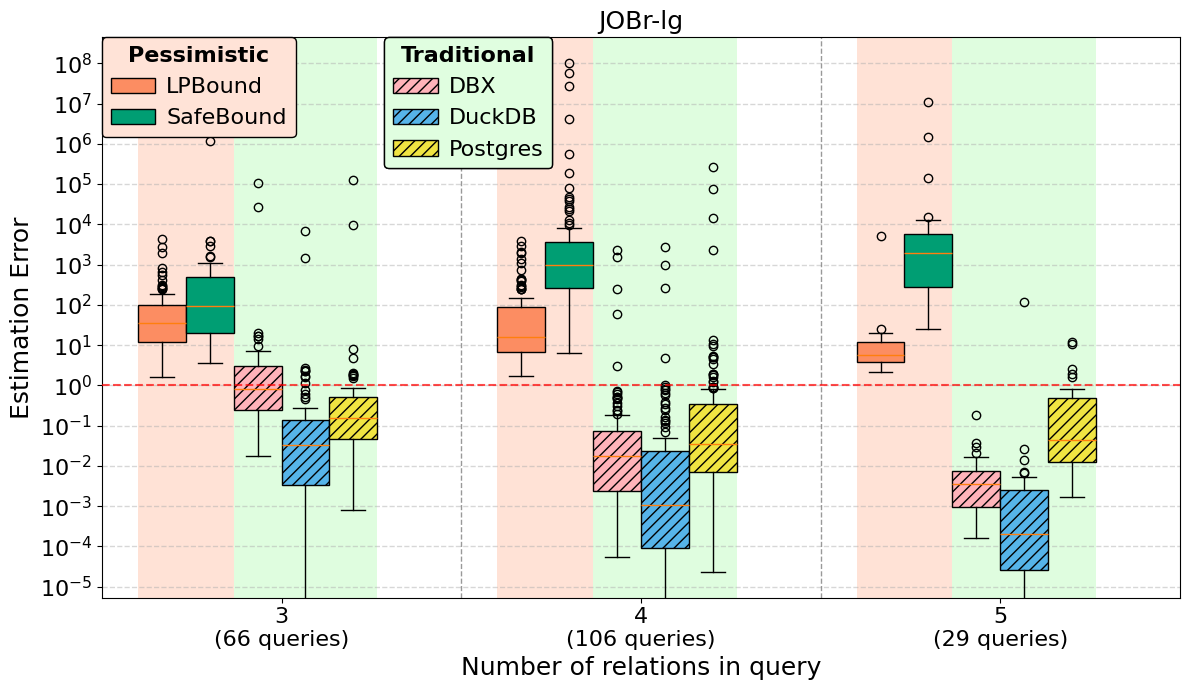

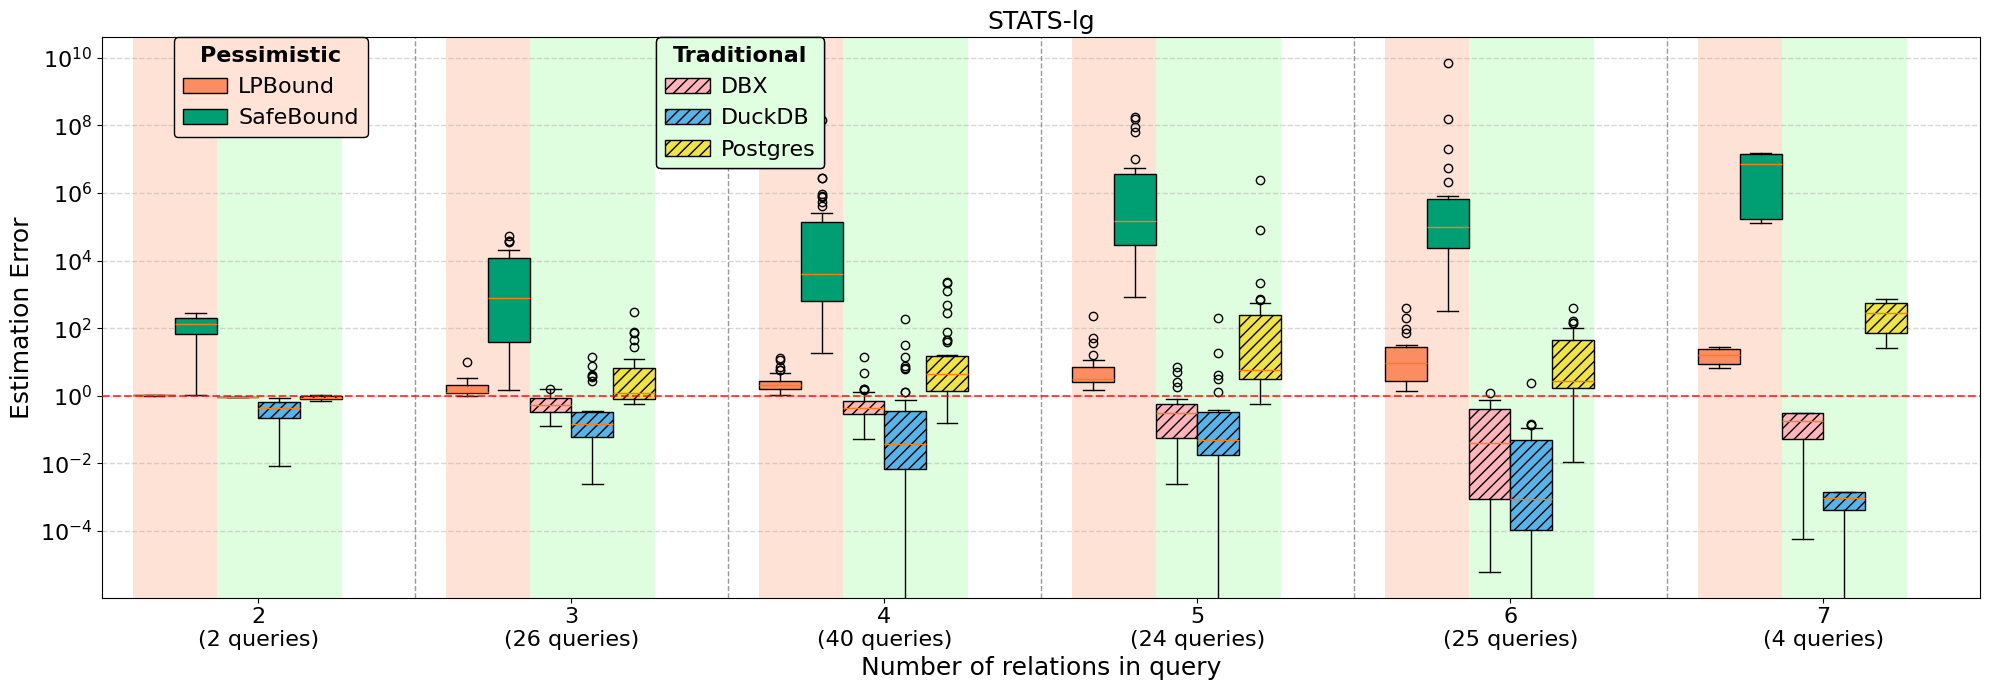

In [17]:
_df, _title, _methods = draw_groupby_estimates("joblight", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "large")
draw_trend_plot(_df, _title, _methods, draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))